In [1]:
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
import sklearn.metrics
import sklearn.preprocessing
from numpy import interp

/usr/local/lib/python3.8/site-packages/tensorflow/python/framework/dtypes.py:513: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  np.object,


AttributeError: module 'numpy' has no attribute 'object'.
`np.object` was a deprecated alias for the builtin `object`. To avoid this error in existing code, use `object` by itself. Doing this will not modify any behavior and is safe. 
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [76]:
# 資料集路徑
datasetPath  = 'data'
# 影像大小
sizeImage = (224, 224)
# 影像類別數/batch size
classNumbers  = 10
sizeBatch = 8
# 凍結層數
freezeLayer = 2
# Epoch 數
epochTimes = 30
# 模型輸出儲存的檔案
modelOutput = 'resnet50_model.h5'

# 將資料集裡的照片縮放、旋轉等產生更多訓練用資料
train_datagen = ImageDataGenerator(rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   channel_shift_range=10,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

train_batches = train_datagen.flow_from_directory(datasetPath + '/train',
                                                  target_size=sizeImage,
                                                  interpolation='bicubic',
                                                  class_mode='categorical',
                                                  shuffle=True,
                                                  batch_size=sizeBatch)

valid_datagen = ImageDataGenerator()
valid_batches = valid_datagen.flow_from_directory(datasetPath + '/valid',
                                                  target_size=sizeImage,
                                                  interpolation='bicubic',
                                                  class_mode='categorical',
                                                  shuffle=False,
                                                  batch_size=sizeBatch)

# 輸出各類別的索引值
for cls, idx in train_batches.class_indices.items():
    print('Class #{} = {}'.format(idx, cls))

# 以訓練好的 ResNet50 為基礎來建立模型，
# 捨棄 ResNet50 頂層的 fully connected layers
net = ResNet50(include_top=False, weights='imagenet', input_tensor=None,
               input_shape=(sizeImage[0],sizeImage[1],3))
x = net.output
x = Flatten()(x)

# 增加 DropOut layer
x = Dropout(0.5)(x)

# 增加 Dense layer，以 softmax 產生個類別的機率值
output_layer = Dense(classNumbers, activation='softmax', name='softmax')(x)

# 設定凍結與要進行訓練的網路層
net_final = Model(inputs=net.input, outputs=output_layer)
for layer in net_final.layers[:freezeLayer]:
    layer.trainable = False
for layer in net_final.layers[freezeLayer:]:
    layer.trainable = True

# 使用 Adam optimizer，以較低的 learning rate 進行 fine-tuning
net_final.compile(optimizer=Adam(lr=1e-5),loss='categorical_crossentropy', metrics=['accuracy'])
#net_final.compile(optimizer=Adam(lr=1e-3),loss='categorical_crossentropy', metrics=['accuracy'])

# 輸出整個網路結構
print(net_final.summary())

# 訓練模型
net_final.fit_generator(train_batches,
                        steps_per_epoch = train_batches.samples // sizeBatch,
                        validation_data = valid_batches,
                        validation_steps = valid_batches.samples // sizeBatch,
                        epochs = epochTimes)

# 儲存訓練好的模型
net_final.save(modelOutput)

Found 6332 images belonging to 10 classes.
Found 792 images belonging to 10 classes.
Class #0 = battery
Class #1 = biological
Class #2 = glass
Class #3 = metal
Class #4 = metal_container
Class #5 = paper
Class #6 = paper_container
Class #7 = plastic_bag
Class #8 = plastic_container
Class #9 = trash
Model: "functional_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]   

In [78]:
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import load_model
from tensorflow.python.keras.preprocessing import image
import sys
import numpy as np
import os

# 從參數讀取圖檔路徑
files =[]
path="data/test" #請改成資料集的位置
for foldername in os.listdir(path):
    files.append([])

cls_list = ['battery', 'biological', 'glass', 'metal', 'metal_container', 'paper',
            'paper_container', 'plastic_bag', 'plastic_container', 'trash']

i=0
for foldername in os.listdir(path):
    if foldername[0].isalpha():
        for filename in os.listdir(path+'/'+foldername):
            #print(filename)
            files[i].append([path+'/'+foldername+'/'+filename,foldername])
        i+=1
            
# 載入訓練好的模型
net = load_model('resnet50_model.h5')

right = 0
total = 0
accuracy_class = []
wrong_pic = []
y_pred = []
y_true = []

# 辨識每一張圖
for c in files:
    right_class = 0
    total_class = 0
    for f in c:
        img = image.load_img(f[0], target_size=(224, 224))
        if img is None:
            continue
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis = 0)
        pred = net.predict(x)[0]
        top_inds = pred.argsort()[::-1][0]
        y_pred.append(top_inds)
        y_true.append(cls_list.index(f[1]))
        '''
        print(f[1])
        print(cls_list[top_inds])
        '''
        total += 1
        total_class += 1
        if f[1] == cls_list[top_inds]:
            right += 1
            right_class += 1
        else:
            wrong_pic.append([f[0],f[1],cls_list[top_inds]])
    accuracy_class.append(right_class / total_class)
        #for i in top_inds:
            #print('    {:.3f}  {}'.format(pred[i], cls_list[i]))

accuracy = right / total
print(accuracy)
print(accuracy_class)

0.9507575757575758
[0.9647058823529412, 0.9361702127659575, 0.9154929577464789, 0.96, 1.0, 1.0, 0.8867924528301887, 1.0, 0.9591836734693877, 0.9387755102040817]


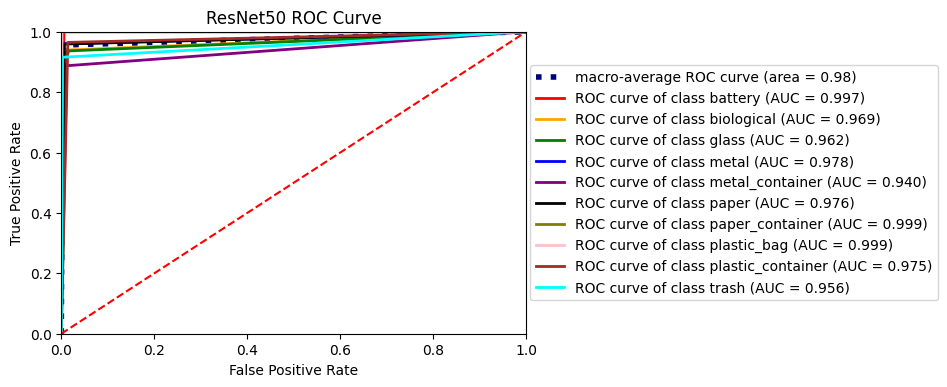

value
Accuracy   0.950758
F1-Score   0.945499
Recall     0.956112
precision  0.936633

battery  biological  glass  metal  metal_container  paper  \
battery                 95           0      0      0                0      0   
biological               0          92      5      0                0      0   
glass                    2           1    132      0                2      1   
metal                    0           0      0     24                1      0   
metal_container          0           0      1      2               47      0   
paper                    2           0      1      1                0    188   
paper_container          0           0      0      0                0      0   
plastic_bag              0           0      0      0                0      0   
plastic_container        0           0      0      0                2      1   
trash                    0           0      1      0                0      2   

                   paper_container  plastic_bag  plastic_container  trash  
battery                          0            0                  0      0  
biological                       0            0                  0      1  
glass                            0            0                  3      0  
metal                            0            0                  0      0  
metal_container                  0            0                  2      1  
paper                            1            1                  2      0  
paper_container                 20            0                  0      0  
plastic_bag                      0            8                  0      0  
plastic_container                0            0                 82      0  
trash                            0            0                  3     65

In [140]:
result_table = []
index = []
index.append("Accuracy")
result_table.append(sklearn.metrics.accuracy_score(y_true, y_pred))
index.append("F1-Score")
result_table.append(sklearn.metrics.f1_score(y_true, y_pred, average='macro'))
index.append("Recall")
result_table.append(sklearn.metrics.recall_score(y_true, y_pred, average='macro'))
index.append("precision")
result_table.append(sklearn.metrics.precision_score(y_true, y_pred, average='macro'))

arr = pd.DataFrame(result_table, index = index, columns = ["value"])


confusion_matrix_p = sklearn.metrics.confusion_matrix(y_true, y_pred)
df = pd.DataFrame(confusion_matrix_p, index =cls_list,
                                              columns =cls_list)

y_true_binary = sklearn.preprocessing.label_binarize(y_true, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
y_pred_binary = sklearn.preprocessing.label_binarize(y_pred, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

fpr = [[]]
tpr = [[]]
threshold = [[]]
roc_auc = [[]]

for i in range(len(cls_list)):
    fpr_i, tpr_i, threshold_i = sklearn.metrics.roc_curve(y_true_binary[:, i], y_pred_binary[:, i])
    fpr.append(fpr_i)
    tpr.append(tpr_i)
    threshold.append(threshold_i)
    roc_auc.append(sklearn.metrics.auc(fpr[i+1], tpr[i+1]))
    #print(fpr, tpr, threshold)

all_fpr = np.unique(np.concatenate([fpr[i] for i in range(len(cls_list))]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(len(cls_list)):
    mean_tpr += interp(all_fpr, fpr[i+1], tpr[i+1])
    
mean_tpr /= len(cls_list)
fpr[0] = all_fpr
tpr[0] = mean_tpr
roc_auc[0] = sklearn.metrics.auc(fpr[0], tpr[0])
    
## Plot the result
plt.figure()
plt.title('ResNet50 ROC Curve')
plt.plot(fpr[0], tpr[0],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc[0]),
         color='navy', linestyle=':', linewidth=4)
colors = ['red', 'orange', 'green', 'blue', 'purple', 'black', 'olive', 'pink' , 'brown', 'cyan']
for i, color in zip(range(len(cls_list)), colors):
    plt.plot(fpr[i+1], tpr[i+1], color=color, lw=2,
             label='ROC curve of class {0} (AUC = {1:0.3f})'
             ''.format(cls_list[i], roc_auc[i+1]))
plt.legend(bbox_to_anchor=(1.9, 0.5),loc = 'right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()    
display(arr)

df

<Figure size 5000x1000 with 0 Axes>

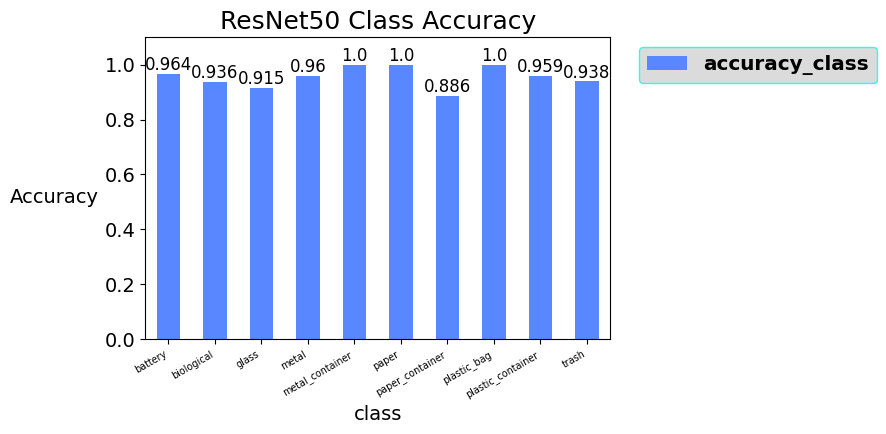

In [141]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.font_manager import FontProperties
font = FontProperties(fname=r"c:\windows\fonts\Microsoft JhengHei.ttc", size=10)

dict = {'classes': cls_list, 'accuracy_class': accuracy_class}

df = pd.DataFrame(dict)

# 開始畫圖

# 圖片大小
plt.figure(figsize=(50, 10)) 
#圖片像素
plt.rcParams['savefig.dpi'] = 100 
#分辨
plt.rcParams['figure.dpi'] = 100 

# ----------------------------------------------------------------------------------------------------------------------

# 劃出柱狀圖

# 抓取select_df的sports、nums欄位，並以sports當x軸，畫出一個bar，顏色為#5887ff
ax = df[['classes', 'accuracy_class']].plot(x='classes', kind='bar', color='#5887ff')

# ----------------------------------------------------------------------------------------------------------------------

# 在畫布上顯示標籤、修改x軸、y軸資訊

#用來顯示正常的中文標籤
plt.rcParams['font.sans-serif']=['Microsoft JhengHei'] 
#標題
plt.title("ResNet50 Class Accuracy", fontsize="18") 
#X軸的名稱、字體大小
plt.xlabel("class", fontsize="14") 
#Y軸名稱、字體大小、轉方向、靠旁邊
plt.ylabel("Accuracy", fontsize="14", rotation=360, horizontalalignment='right', verticalalignment='top') 

#刻度
#X軸刻度大小、轉方向
plt.xticks(fontsize=10, rotation=360)
#Y軸刻度大小
plt.yticks(fontsize=14)

#Y軸座標範圍
plt.ylim([0, 100]) 

plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left", fontsize = 'x-large', edgecolor = '#00ffee', facecolor = 'lightgray', title = '')


leg = plt.gca().get_legend()
ltext = leg.get_texts()
plt.setp(ltext, fontweight='bold') 

x = df['classes'].tolist()
y= df['accuracy_class'].tolist()
#l是要放入X軸的index
l=[i for i in range(len(df))]
for i,(_x,_y) in enumerate(zip(l, y)):  
    plt.text(_x, _y, str(y[i])[0:5], ha='center', va= 'bottom', color='black', fontsize=12)  

plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right', fontsize='x-small')
plt.axis([None, None, 0, 1.1])
#把圖顯示出來
plt.show() 

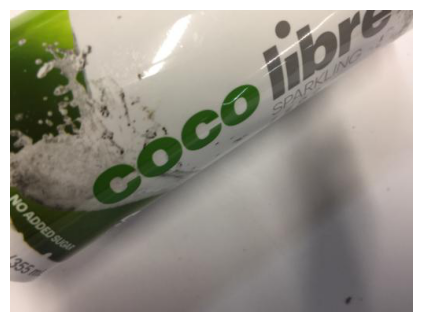

正確：plastic_container｜預測：paper


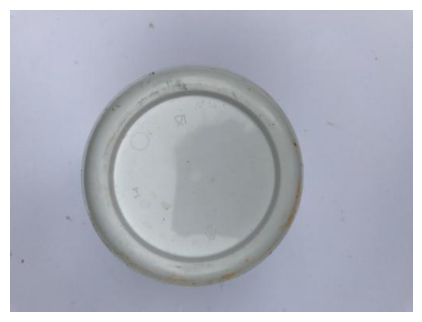

正確：plastic_container｜預測：metal_container


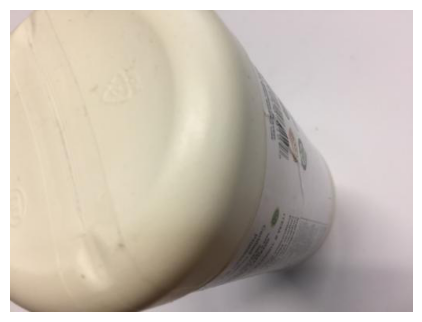

正確：plastic_container｜預測：metal_container


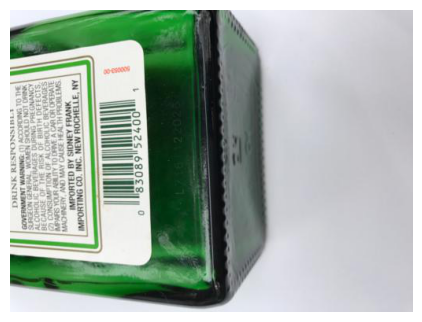

正確：glass｜預測：battery


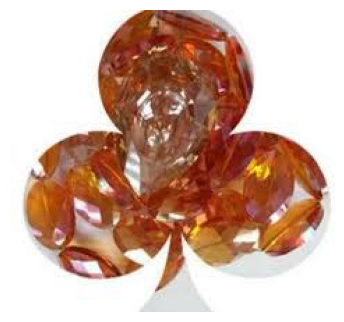

正確：glass｜預測：biological


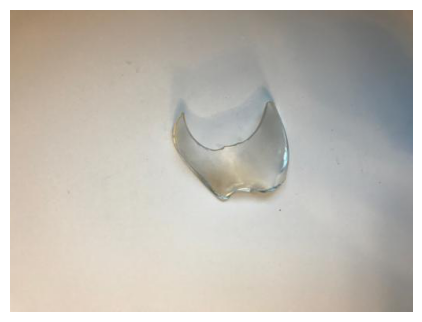

正確：glass｜預測：paper


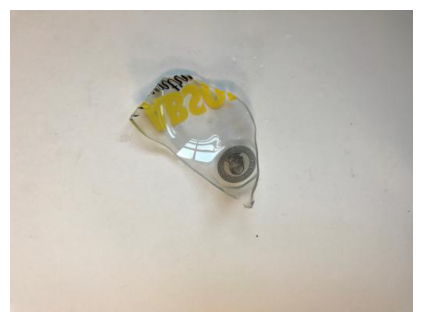

正確：glass｜預測：metal_container


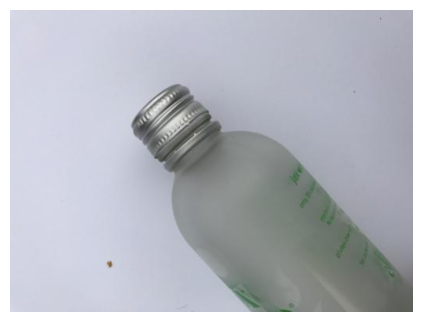

正確：glass｜預測：plastic_container


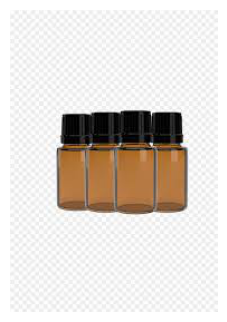

正確：glass｜預測：battery


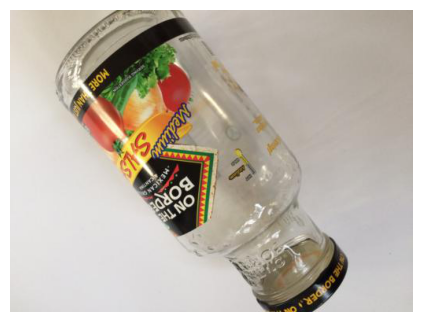

正確：glass｜預測：plastic_container


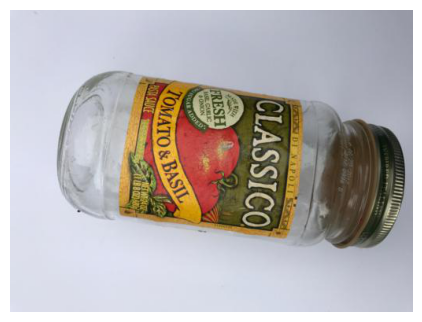

正確：glass｜預測：metal_container


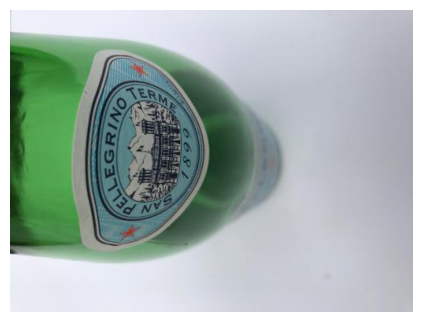

正確：glass｜預測：plastic_container


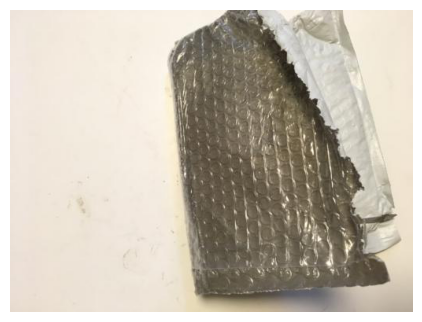

正確：trash｜預測：paper


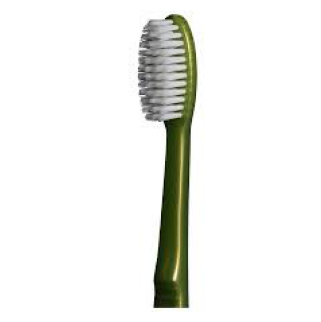

正確：trash｜預測：glass


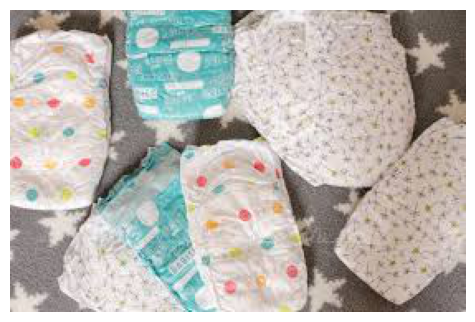

正確：trash｜預測：plastic_container


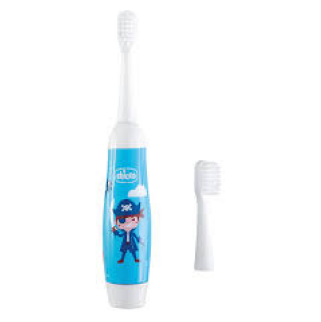

正確：trash｜預測：plastic_container


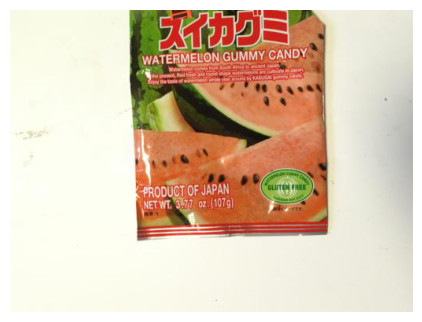

正確：trash｜預測：paper


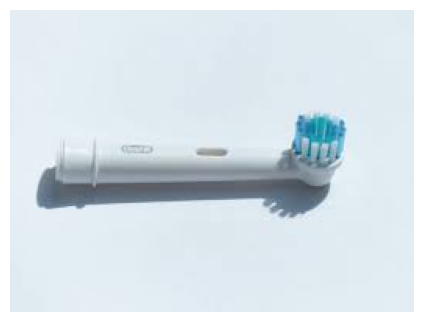

正確：trash｜預測：plastic_container


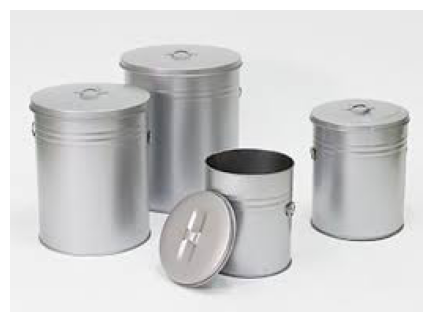

正確：metal｜預測：metal_container


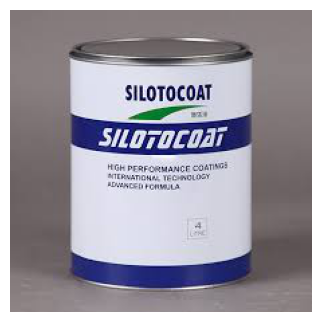

正確：metal_container｜預測：plastic_container


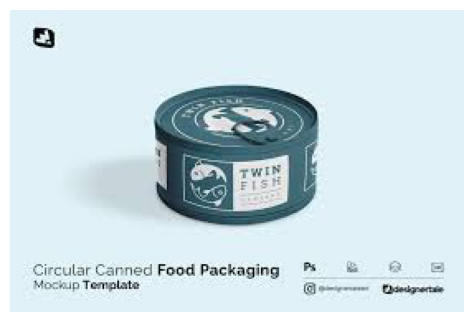

正確：metal_container｜預測：plastic_container


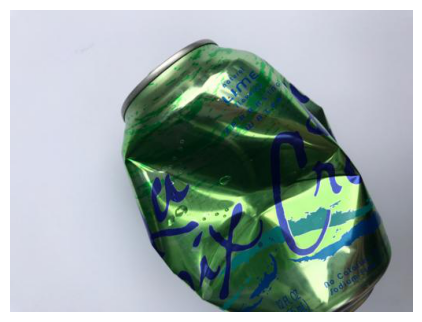

正確：metal_container｜預測：glass


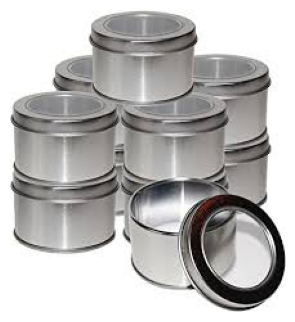

正確：metal_container｜預測：metal


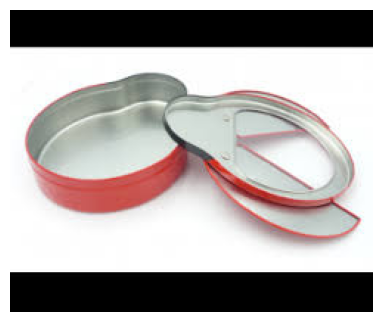

正確：metal_container｜預測：metal


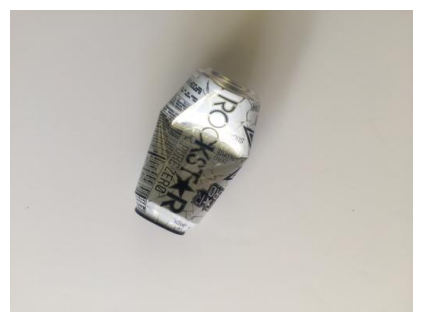

正確：metal_container｜預測：trash


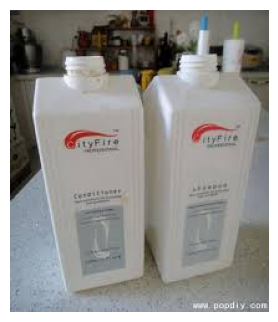

正確：paper｜預測：plastic_container


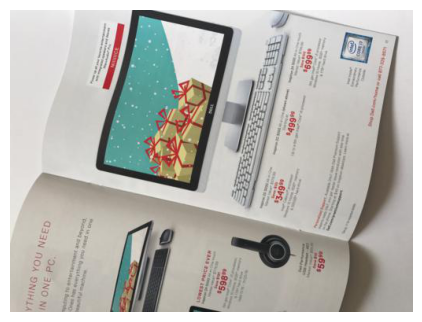

正確：paper｜預測：battery


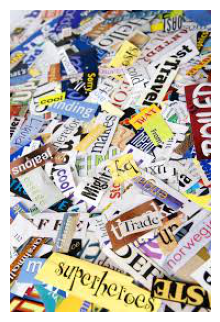

正確：paper｜預測：paper_container


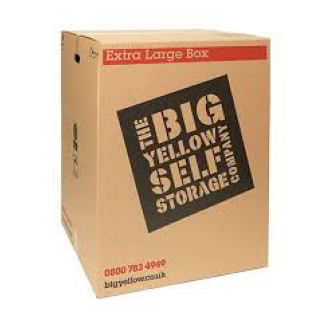

正確：paper｜預測：battery


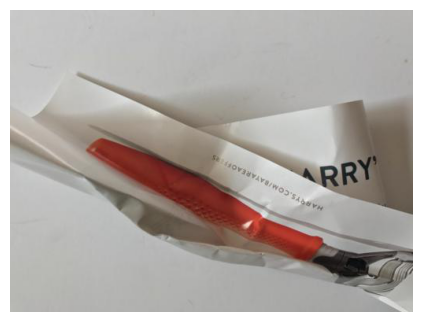

正確：paper｜預測：glass


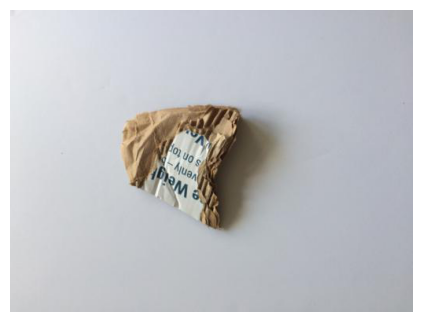

正確：paper｜預測：metal


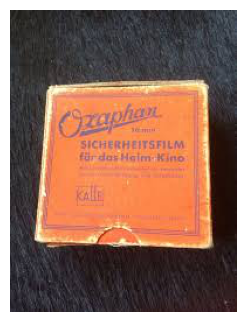

正確：paper｜預測：plastic_bag


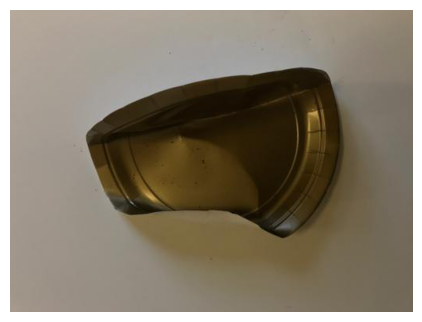

正確：paper｜預測：plastic_container


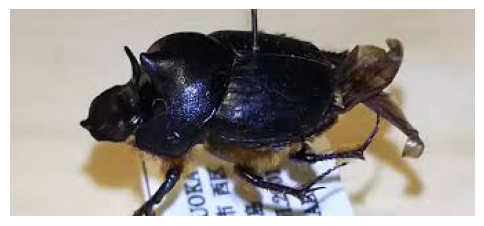

正確：biological｜預測：glass


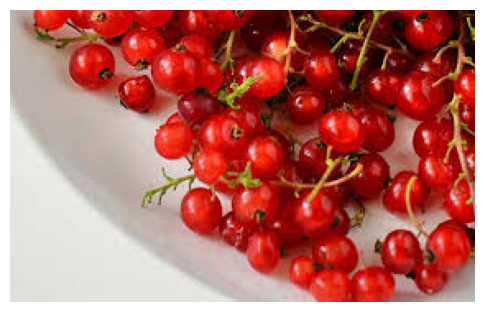

正確：biological｜預測：glass


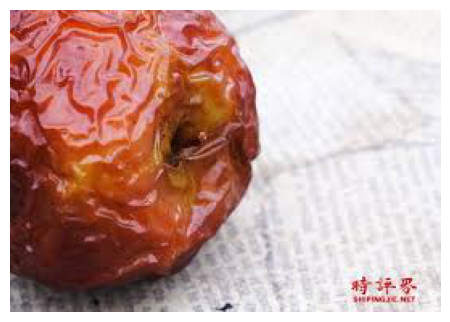

正確：biological｜預測：glass


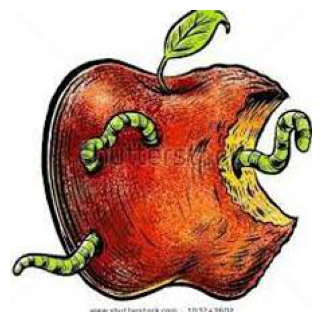

正確：biological｜預測：glass


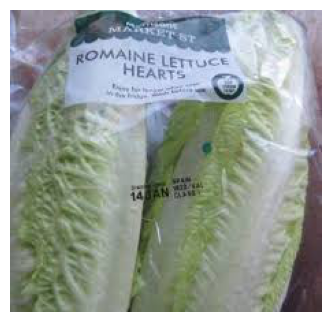

正確：biological｜預測：trash


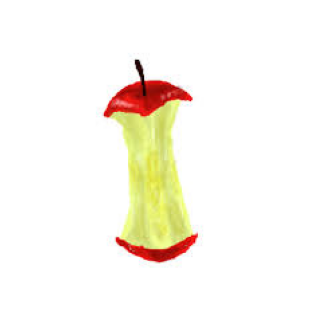

正確：biological｜預測：glass


In [119]:
import matplotlib.image as mpimg
for f in wrong_pic:
    img = mpimg.imread(f[0])
    plt.axis('off')
    imgplot = plt.imshow(img)
    plt.show()
    print("正確："+f[1]+"｜預測："+f[2])

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


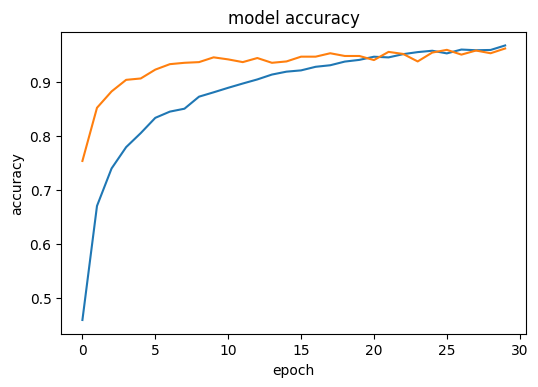

In [133]:
print(net_final.history.history.keys())

plt.plot(net_final.history.history['accuracy'])
plt.plot(net_final.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


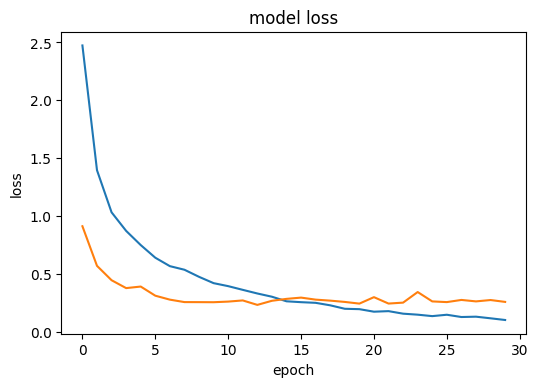

In [134]:
print(net_final.history.history.keys())

plt.plot(net_final.history.history['loss'])
plt.plot(net_final.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()